# Thesis Work - Nov 29 - MobileNetV3-Large

## Importing Necessary Libraries

In [1]:
import os
import random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

## Loading the Dataset's Kaggle Path

In [2]:
# Download the latest version
path = kagglehub.dataset_download("wasifmahmood01/custom-waste-classification-dataset")

print("Path to Dataset Files:", path)

100%|██████████| 5.39G/5.39G [04:21<00:00, 22.1MB/s]

Extracting files...


Path to Dataset Files: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1


In [3]:
for root, dirs, files in os.walk(path):
    print(root)
    # Just show first few files in each directory
    for f in files[:5]:
        print("   ", f)
    print("------")

/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/organic waste
    organic waste (38).png
    organic waste (21).png
    organic waste (75).jpg
    organic waste (91).png
    organic waste (42).png
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/glass waste
    glass waste (119).jpg
    glass waste (249).jpg
    glass waste (230).jpg
    glass waste (5).jpg
    glass waste (78).jpg
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/paper waste
    paper waste (266).jpg
    paper waste (117

## Data Exploration & Preparation


In [4]:
# Update actual dataset path
data_dir = Path(path) / "wastes"
print("Using Data Directory:", data_dir)

Using Data Directory: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes


In [5]:
train_dir = data_dir / "train"
test_dir = data_dir / "test"

               Class  Image_Count
7        paper waste         1370
8      plastic waste         1315
0            E-waste         1248
5        metal waste         1231
3        glass waste         1022
6      organic waste          889
1  automobile wastes          871
2      battery waste          848
4        light bulbs          420


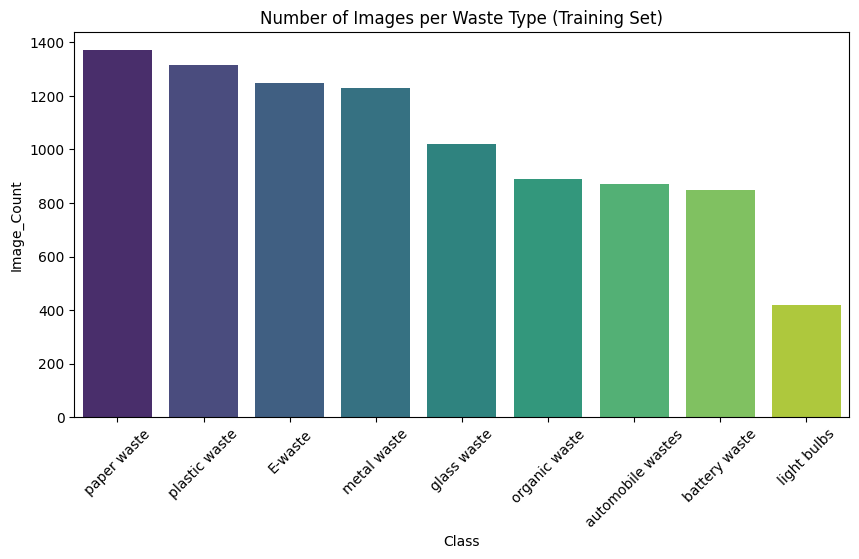

In [6]:
# Count the number of images in each class (from train directory)
classes = sorted(os.listdir(train_dir))
counts = {cls: len(os.listdir(train_dir / cls)) for cls in classes}

df_counts = pd.DataFrame(list(counts.items()), columns = ['Class', 'Image_Count']) \
               .sort_values(by = 'Image_Count', ascending = False)

print(df_counts)

plt.figure(figsize = (10,5))
sns.barplot(data = df_counts, x = 'Class', y = 'Image_Count', hue = 'Class', palette = 'viridis', legend = False)
plt.title("Number of Images per Waste Type (Training Set)")
plt.xticks(rotation = 45)
plt.show()

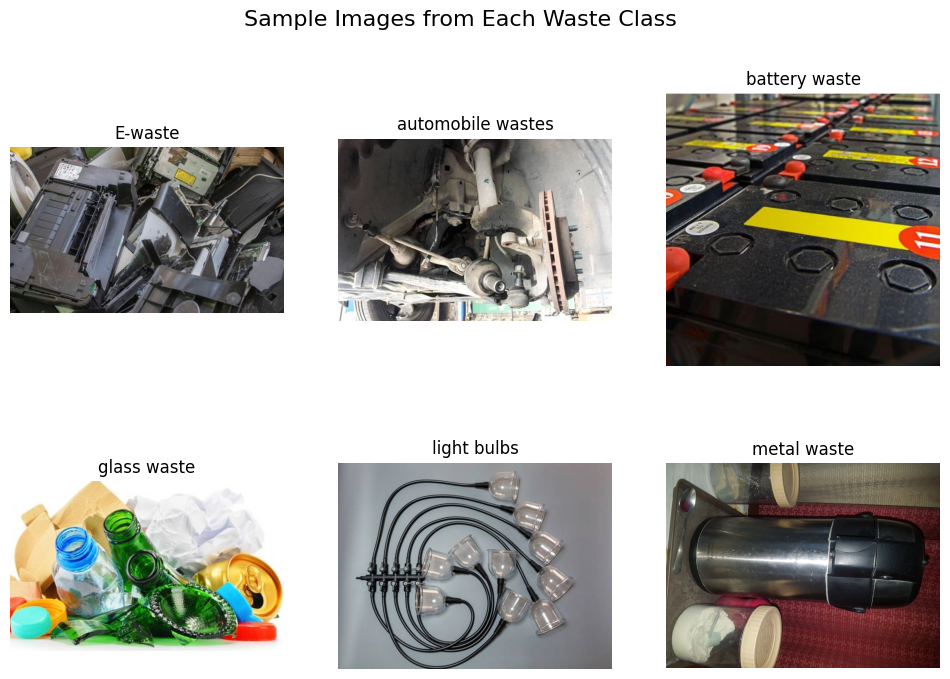

In [7]:
# Preview sample images from each waste class
fig, axes = plt.subplots(2, 3, figsize = (12,8))

for ax, cls in zip(axes.flatten(), classes):
    img_path = train_dir / cls / random.choice(os.listdir(train_dir / cls))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

plt.suptitle("Sample Images from Each Waste Class", fontsize=16)
plt.show()

In [8]:
# Are there any corrupted images? (scanning the training set)
corrupted = []

for cls in classes:
    folder = train_dir / cls
    for file in os.listdir(folder):
        path_img = folder / file
        try:
            img = Image.open(path_img)
            img.verify()
        except:
            corrupted.append(str(path_img))

print(f"{len(corrupted)} corrupted images found.")
if corrupted:
    print("Example:", corrupted[:3])

0 corrupted images found.


Scanning plastic waste: 100%|██████████| 1315/1315 [00:00<00:00, 7931.53it/s]


             Width       Height
count  9214.000000  9214.000000
mean    949.699045   800.735620
std    1145.343332  1017.750853
min      52.000000    40.000000
25%     408.000000   324.000000
50%     586.000000   408.000000
75%     622.000000   612.000000
max    6898.000000  7262.000000


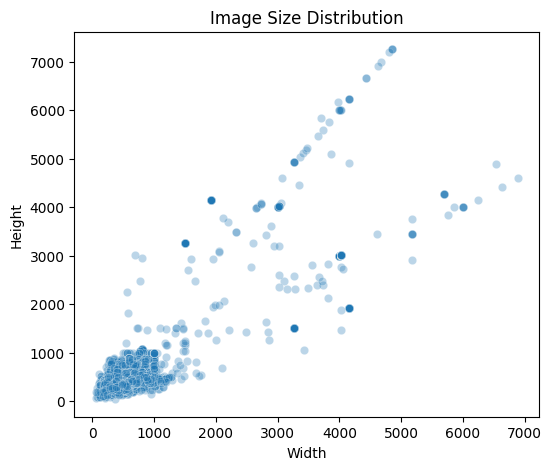

In [9]:
dims = []

for cls in classes:
    folder = train_dir / cls
    for file in tqdm(os.listdir(folder), desc = f"Scanning {cls}"):
        path_img = folder / file
        try:
            with Image.open(path_img) as img:
                dims.append(img.size)
        except:
            pass  # catch corrupted images

df_dims = pd.DataFrame(dims, columns = ['Width', 'Height'])
print(df_dims.describe())

plt.figure(figsize = (6,5))
sns.scatterplot(data = df_dims, x = 'Width', y = 'Height', alpha = 0.3)
plt.title("Image Size Distribution")
plt.show()

## Adding Generators

In [10]:
# ===============================
#  DATA GENERATORS  (FIXED)
# ===============================

img_size = (320, 320)
batch_size = 32

# Training Data Augmentation with validation split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # This is crucial
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode="nearest",
)

# Test generator (NO validation split)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

classes = sorted(os.listdir(train_dir))

print("Available classes:", classes)

# Train Generator (SUBSET: training)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",  # This is important
    shuffle=True,
    classes=classes
)

# Validation Generator (SUBSET: validation) - MUST use same datagen as train
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",  # This is important
    shuffle=False,
    classes=classes
)

# Test Generator - different datagen, no subset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    classes=classes
)

print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)

num_classes = len(classes)

Available classes: ['E-waste', 'automobile wastes', 'battery waste', 'glass waste', 'light bulbs', 'metal waste', 'organic waste', 'paper waste', 'plastic waste']
Found 7374 images belonging to 9 classes.
Found 1840 images belonging to 9 classes.
Found 2308 images belonging to 9 classes.
Train samples: 7374
Validation samples: 1840
Test samples: 2308


## Compute Class Weights

In [11]:
# ===============================
#  CLASS WEIGHTS (FIXED)
# ===============================

y_train = train_generator.classes

weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Correct mapping of class names to indices
class_indices = train_generator.class_indices
class_weights = {class_indices[c]: weights_array[i] for i, c in enumerate(classes)}

print("Fixed Class Weights:", class_weights)

print("TRAIN DIR:", train_dir)
print("CLASSES FOUND:", os.listdir(train_dir))

for c in os.listdir(train_dir):
    folder = os.path.join(train_dir, c)
    print(c, "->", len(os.listdir(folder)), "files")

Fixed Class Weights: {0: np.float64(0.8201534868201534), 1: np.float64(1.1755141080822573), 2: np.float64(1.2066764850270004), 3: np.float64(1.0016299918500406), 4: np.float64(2.4384920634920637), 5: np.float64(0.8318104906937395), 6: np.float64(1.150749063670412), 7: np.float64(0.7475669099756691), 8: np.float64(0.7788339670468948)}
TRAIN DIR: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train
CLASSES FOUND: ['organic waste', 'glass waste', 'paper waste', 'plastic waste', 'automobile wastes', 'metal waste', 'E-waste', 'light bulbs', 'battery waste']
organic waste -> 889 files
glass waste -> 1022 files
paper waste -> 1370 files
plastic waste -> 1315 files
automobile wastes -> 871 files
metal waste -> 1231 files
E-waste -> 1248 files
light bulbs -> 420 files
battery waste -> 848 files


## Model Building - MobileNetV3 Large

In [12]:
# ===============================
#  BUILD MODEL (MobileNetV3-Large)
# ===============================

base_model = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(320, 320, 3)
)

base_model.trainable = False  # Freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)

# BETTER CLASSIFICATION HEAD
x = layers.Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 320, 320,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 160, 160,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 160, 160,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 160, 160,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 160, 160,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 160, 160,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 160, 160,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 161, 161,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        256 │ expanded_conv_1_

 Total params: 3,276,425 (12.50 MB)

 Trainable params: 280,073 (1.07 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Model Training

In [13]:
# ===============================
#  TRAIN FROZEN MODEL
# ===============================

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

frozen_train_acc = max(history_frozen.history['accuracy'])
frozen_val_acc = max(history_frozen.history['val_accuracy'])

print(f"Best Frozen Train Acc: {frozen_train_acc*100:.2f}%")
print(f"Best Frozen Val Acc:   {frozen_val_acc*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.2056 - loss: 2.3535 - val_accuracy: 0.5880 - val_loss: 1.3486 - learning_rate: 1.0000e-04
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.5306 - loss: 1.3695 - val_accuracy: 0.6457 - val_loss: 1.0487 - learning_rate: 1.0000e-04
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.6391 - loss: 1.0550 - val_accuracy: 0.6576 - val_loss: 0.9721 - learning_rate: 1.0000e-04
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.6810 - loss: 0.8999 - val_accuracy: 0.6951 - val_loss: 0.8969 - learning_rate: 1.0000e-04
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.7225 - loss: 0.8052 - val_accuracy: 0.7147 - val_loss: 0.8543 - learning_rate: 1.0000e-04
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7345 - loss: 0.7584 - val_accuracy: 0.7261 - val_loss: 0.8093 - learning_rate: 1.0000e-04
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - acc

In [14]:
# ===============================
#  GET FINAL EPOCH VALUES
# ===============================

final_train_acc = history_frozen.history['accuracy'][-1]
final_val_acc = history_frozen.history['val_accuracy'][-1]
final_train_loss = history_frozen.history['loss'][-1]
final_val_loss = history_frozen.history['val_loss'][-1]

print(f"Final Epoch Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Epoch Validation Accuracy: {final_val_acc*100:.2f}%")
print()
print(f"Final Epoch Training Loss: {final_train_loss:.4f}")
print(f"Final Epoch Validation Loss: {final_val_loss:.4f}")

Final Epoch Training Accuracy: 78.94%
Final Epoch Validation Accuracy: 74.89%

Final Epoch Training Loss: 0.5833
Final Epoch Validation Loss: 0.7270


## Model Evaluation

In [15]:
# ===============================
#  EVALUATE FROZEN MODEL
# ===============================

eval_gen = test_generator
steps = int(np.ceil(eval_gen.samples / eval_gen.batch_size))

preds = model.predict(eval_gen, steps=steps)
y_pred = np.argmax(preds, axis=1)
y_true = eval_gen.classes

labels = [lab for lab, idx in sorted(eval_gen.class_indices.items(), key=lambda x: x[1])]

print("Classification Report - Frozen MobileNetV3 Model")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1 Score - Frozen MobileNetV3 Model: {macro_f1:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 60s 732ms/step
Classification Report - Frozen MobileNetV3 Model
                   precision    recall  f1-score   support

          E-waste       0.83      0.82      0.82       313
automobile wastes       0.82      0.90      0.86       218
    battery waste       0.85      0.86      0.86       213
      glass waste       0.83      0.79      0.81       256
      light bulbs       0.81      0.86      0.83       105
      metal waste       0.78      0.81      0.79       308
    organic waste       0.89      0.94      0.91       223
      paper waste       0.93      0.87      0.89       343
    plastic waste       0.79      0.76      0.77       329

         accuracy                           0.84      2308
        macro avg       0.84      0.84      0.84      2308
     weighted avg       0.84      0.84      0.84      2308

Macro F1 Score - Frozen MobileNetV3 Model: 0.8401


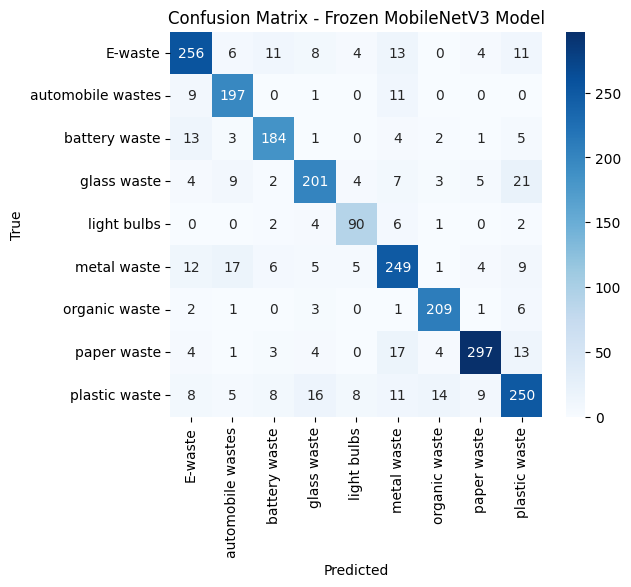

In [16]:
# ====================================
#  CONFUSION MATRICES (FROZEN MODEL)
# ====================================

cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Frozen MobileNetV3 Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

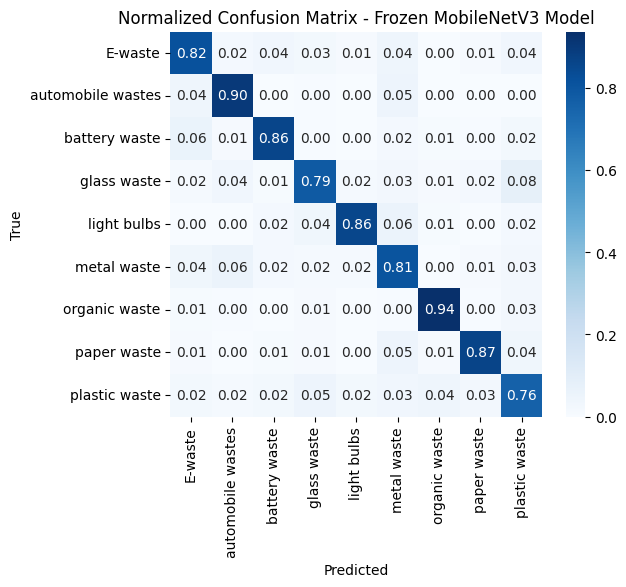

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix - Frozen MobileNetV3 Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Fine-Tuning, Training, & Evaluation

In [18]:
# ===============================
#  FINE-TUNING SETUP
# ===============================

for layer in base_model.layers[-80:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
# ===============================
#  TRAIN FINE-TUNED MODEL
# ===============================

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

ft_train_acc = max(history_ft.history['accuracy'])
ft_val_acc = max(history_ft.history['val_accuracy'])

print(f"Fine-Tuned Final Epoch Training Accuracy: {ft_train_acc*100:.2f}%")
print(f"Fine-tuned Final Epoch Validation Accuracy:   {ft_val_acc*100:.2f}%")

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.7128 - loss: 0.8046 - val_accuracy: 0.7554 - val_loss: 0.7142 - learning_rate: 1.0000e-05
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.7595 - loss: 0.6730 - val_accuracy: 0.7462 - val_loss: 0.7346 - learning_rate: 1.0000e-05
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.7666 - loss: 0.6656 - val_accuracy: 0.7522 - val_loss: 0.7219 - learning_rate: 1.0000e-05
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7738 - loss: 0.6213 - val_accuracy: 0.7505 - val_loss: 0.7223 - learning_rate: 1.0000e-05
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8001 - loss: 0.5577 - val_accuracy: 0.7603 - val_loss: 0.6988 - learning_rate: 3.0000e-06
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8049 - loss: 0.5480 - val_accuracy: 0.7641 - val_loss: 0.6951 - learning_rate: 3.0000e-06
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - acc

In [20]:
# ===============================
#  FINAL EVALUATION (FINE-TUNED)
# ===============================

steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
preds = model.predict(test_generator, steps=steps)

y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print("Classification Report - Fine-Tuned MobileNetV3 Model")
print(classification_report(y_true, y_pred, target_names = labels, zero_division=0))

macro_f1 = f1_score(y_true, y_pred, average = "macro")
print(f"Final Macro F1 Score - Fine-Tuned MobileNetV3 Model: {macro_f1:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 601ms/step
Classification Report - Fine-Tuned MobileNetV3 Model
                   precision    recall  f1-score   support

          E-waste       0.86      0.78      0.82       313
automobile wastes       0.83      0.91      0.87       218
    battery waste       0.80      0.91      0.85       213
      glass waste       0.82      0.84      0.83       256
      light bulbs       0.71      0.88      0.79       105
      metal waste       0.77      0.81      0.79       308
    organic waste       0.93      0.91      0.92       223
      paper waste       0.93      0.87      0.90       343
    plastic waste       0.83      0.72      0.77       329

         accuracy                           0.84      2308
        macro avg       0.83      0.85      0.84      2308
     weighted avg       0.84      0.84      0.84      2308

Final Macro F1 Score - Fine-Tuned MobileNetV3 Model: 0.8366


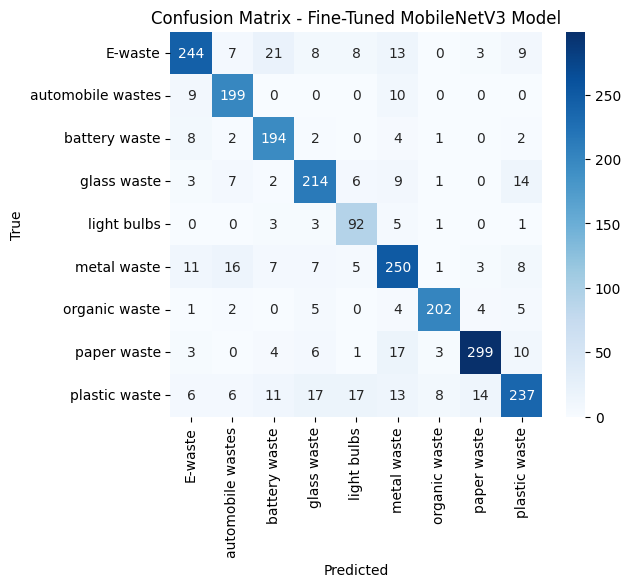

In [21]:
# ====================================
#  CONFUSION MATRICES (FINE-TUNED)
# ====================================

cm_fine_tinued = confusion_matrix(y_true, y_pred)
cm_norm_fine_tuned = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize = (6,5))
sns.heatmap(cm_fine_tinued, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fine-Tuned MobileNetV3 Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

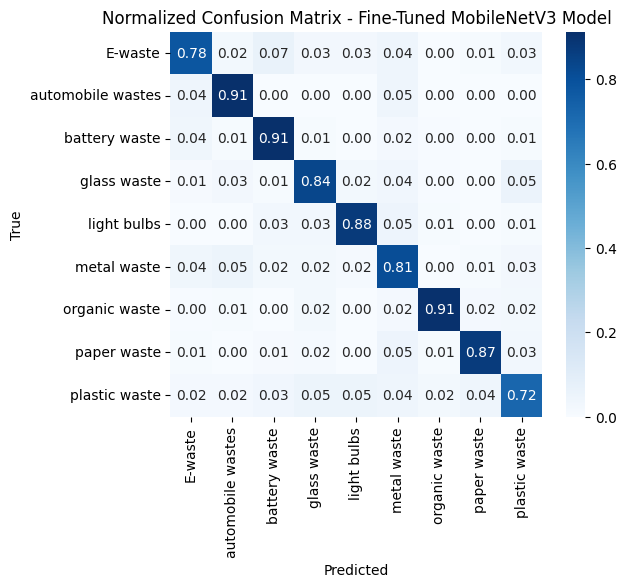

In [22]:
plt.figure(figsize = (6,5))
sns.heatmap(cm_norm_fine_tuned, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix - Fine-Tuned MobileNetV3 Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()